In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import komm
import scienceplots

plt.style.use("science")

In [2]:
n = 8
k = 4
m = n - k

G = np.array(
    [
        [1, 0, 0, 0, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0],
    ]
)

In [3]:
u = np.array(list(it.product([0, 1], repeat=k)))
v = (u @ G) % 2

v_weights = np.unique(np.sum(v, axis=1), return_counts=True)
d_min = v_weights[0][1]

In [4]:
H = np.array(
    [
        [1, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]
)

(np.array([(vi.T @ H) % 2 for vi in v]).ravel() == 1).any()

np.False_

In [5]:
ap = np.zeros((2**m, 2**k, n), dtype=int)

ap[0, :, :] = v


def error_patterns(bits: int):
    for i in range(bits + 1):
        positions = it.combinations(range(bits), i)
        for p in positions:
            error = np.zeros(bits, dtype=int)
            error[list(p)] = 1
            yield error


gen = error_patterns(n)

for row in range(1, ap.shape[0]):
    next_error_pattern = next(gen)
    while np.any(np.all(next_error_pattern == ap, axis=(1, 2))):
        next_error_pattern = next(gen)

    ap[row, :, :] = (ap[0, :, :] + next_error_pattern) % 2

e = ap[:, 0, :]
s = ((H.T @ e.T) % 2).T
s_e_map = {tuple(s): e for s, e in zip(s, e)}

e_weights = np.unique(np.sum(e, axis=1), return_counts=True)

In [ ]:
n_symbols = 100_000
u = np.random.randint(0, 2, size=(n_symbols, k))
v = (u @ G) % 2
M = 4
R = k / n

modulation = komm.PSKModulation(M)

Eb_N0s_dB = np.arange(-1, 8)
ber_ncode = np.zeros(len(Eb_N0s_dB))
ber_coded = np.zeros(len(Eb_N0s_dB))

for i, Eb_N0 in enumerate(Eb_N0s_dB):
    snr = R * np.log2(M) * 10 ** (Eb_N0 / 10)
    awgn = komm.AWGNChannel(snr=snr, signal_power="measured")

    v_mod = modulation.modulate(v.ravel())
    v_mod_noisy = awgn(v_mod)
    b = modulation.demodulate(v_mod_noisy).reshape(-1, n)

    s = ((H.T @ b.T) % 2).T
    e = np.array([s_e_map[tuple(i)] for i in s])

    v_hat = (b + e) % 2
    u_hat = v_hat[:, :k]

    ber_coded[i] = np.mean(u.ravel() != u_hat.ravel())

    u_mod = modulation.modulate(u.ravel())
    u_mod_noisy = awgn(u_mod)
    u_hat = modulation.demodulate(u_mod_noisy).reshape(-1, k)

    ber_ncode[i] = np.mean(u.ravel() != u_hat.ravel())

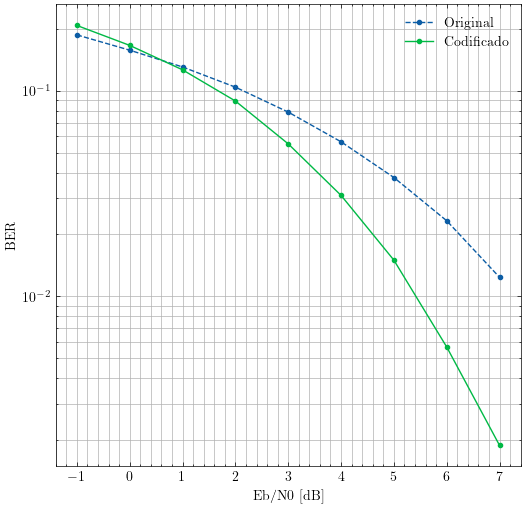

In [ ]:
plt.figure(figsize=(6, 6))

plt.semilogy(Eb_N0s_dB, ber_ncode, linestyle="dashed", marker=".", label="Original")
plt.semilogy(Eb_N0s_dB, ber_coded, linestyle="solid", marker=".", label="Codificado")

plt.xlabel("Eb/N0 [dB]")
plt.ylabel("BER")

plt.legend()
plt.grid(which="both")

plt.show()